# Pneumonia Detection in Xrays

#### This will be my attempt to improve on the model/process done [here](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8) by Abhinav Sagar back in 2019. This is using a dataset of x-rays with a positive or negative pneumonia diagnosis.

### Imports

In [3]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf

import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary

from torchbearer import Trial
from torch import optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

from tqdm import tqdm
from PIL import Image
import os

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

### Process

#### Using the same method as the original post, we can do some exploratory analysis and have a look at what these files look like. Note that in the dataset, the images have already been split into train, val, test.

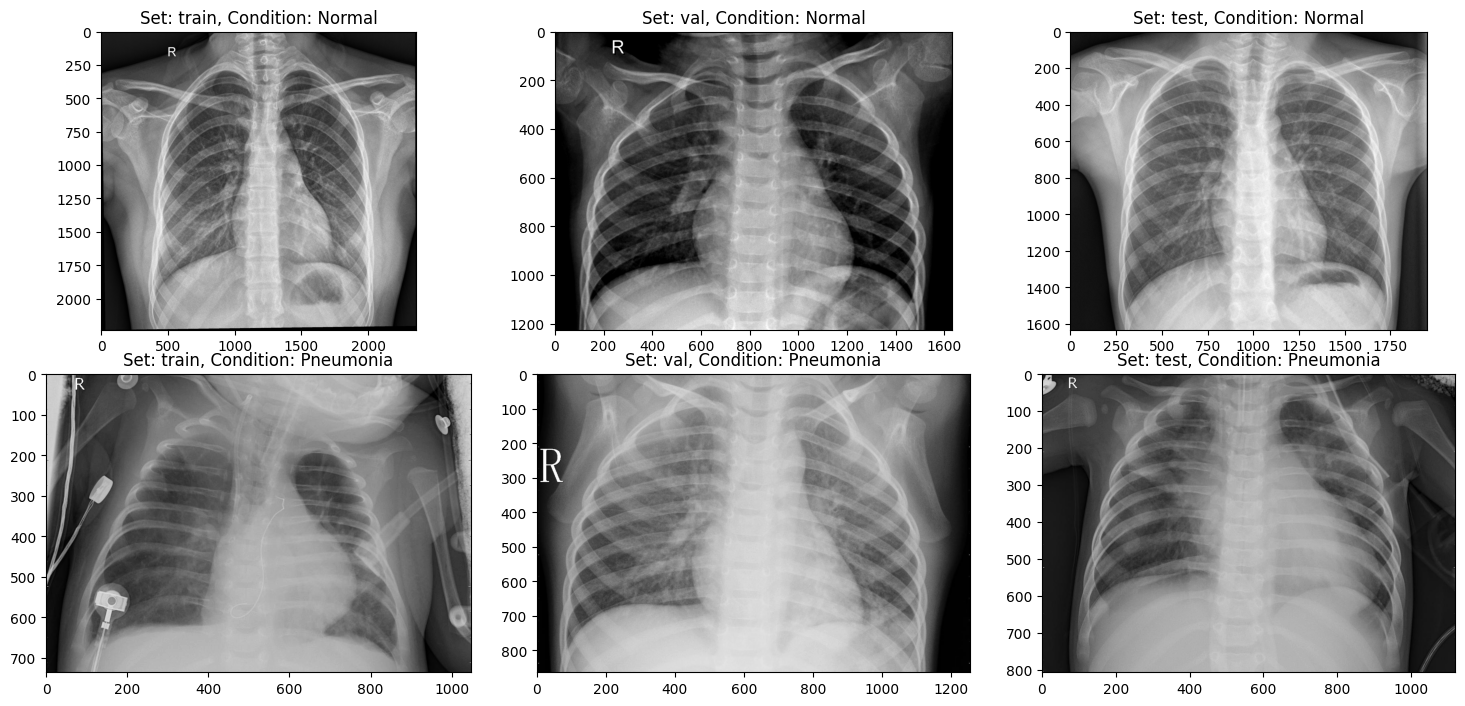

In [4]:
input_path = 'chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = os.path.join(input_path, _set)
    normal_path = os.path.join(set_path, 'NORMAL')
    pneumonia_path = os.path.join(set_path, 'PNEUMONIA')
    
    # filter out .DS_Store files
    normal_files = [file for file in os.listdir(normal_path) if not file.startswith('.')]
    pneumonia_files = [file for file in os.listdir(pneumonia_path) if not file.startswith('.')]
    
    ax[i].imshow(plt.imread(os.path.join(normal_path, normal_files[0])), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(os.path.join(pneumonia_path, pneumonia_files[0])), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))


In [5]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


In [57]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [58]:
train_dataset = datasets.ImageFolder('train/', transform=transform)
val_dataset = datasets.ImageFolder('val/', transform=transform)
test_dataset = datasets.ImageFolder('test/', transform=transform)

## Model

#### Instead of completely creating a new model, I decided to use CheXNet, which has been specifically trained on chest x-rays.

In [64]:
class CheXNet(nn.Module):
    def __init__(self, num_classes=14):
        super(CheXNet, self).__init__()
        self.model = models.densenet121(pretrained=False)
        num_ftrs = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model.features(x)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.model.classifier(x)
        return x

model_path = 'CheXNet/m-25012018-123527.pth.tar'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CheXNet()
model_dict = model.state_dict()
checkpoint = torch.load(model_path, map_location=device)

# remove 'module.' from keys (if present) because the saved model was trained with DataParallel
for k in list(checkpoint['state_dict'].keys()):
    if k.startswith('module.'):
        checkpoint['state_dict'][k[7:]] = checkpoint['state_dict'].pop(k)

# filter out unnecessary keys from the saved state dictionary
checkpoint['state_dict'] = {k:v for k,v in checkpoint['state_dict'].items() if k in model_dict}

model_dict.update(checkpoint['state_dict'])
model.load_state_dict(model_dict)

#model.to(device)

/Users/dhelq/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dhelq/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Early stopping
best_val_accuracy = 0
patience = 5
counter = 0

train_accs = []
val_accs = []

for epoch in tqdm(range(25)):
    # Train
    stepcount = 0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        stepcount += 1
        if stepcount % 20 == 0:
            print(f"Step {stepcount} Complete")

    # Evaluate
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = correct / total
        train_accs.append(train_accuracy)
        
        correct = 0
        total = 0
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_accuracy = correct / total
        val_accs.append(val_accuracy)
        print(f"Epoch {epoch}: val accuracy = {val_accuracy:.4f}")

        # Check for improvement in validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Validation accuracy has not improved in the last {} epochs, stopping early".format(patience))
                break

  0%|          | 0/25 [00:00<?, ?it/s]

Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


  4%|▍         | 1/25 [24:49<9:55:59, 1490.00s/it]

Epoch 0: val accuracy = 0.8125
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


  8%|▊         | 2/25 [49:45<9:32:22, 1493.16s/it]

Epoch 1: val accuracy = 0.6875
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 12%|█▏        | 3/25 [1:14:28<9:05:45, 1488.43s/it]

Epoch 2: val accuracy = 0.8750
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 16%|█▌        | 4/25 [1:38:56<8:38:13, 1480.64s/it]

Epoch 3: val accuracy = 0.6875
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 20%|██        | 5/25 [2:03:49<8:14:59, 1484.96s/it]

Epoch 4: val accuracy = 1.0000
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 24%|██▍       | 6/25 [2:28:42<7:51:04, 1487.58s/it]

Epoch 5: val accuracy = 0.5625
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 28%|██▊       | 7/25 [2:53:20<7:25:21, 1484.55s/it]

Epoch 6: val accuracy = 0.8750
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 32%|███▏      | 8/25 [3:17:22<6:56:44, 1470.87s/it]

Epoch 7: val accuracy = 0.9375
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 36%|███▌      | 9/25 [3:41:31<6:30:24, 1464.03s/it]

Epoch 8: val accuracy = 0.8125
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 36%|███▌      | 9/25 [4:06:16<7:17:48, 1641.80s/it]

Epoch 9: val accuracy = 0.7500
Validation accuracy has not improved in the last 5 epochs, stopping early


In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

for epoch in tqdm(range(10)):
    # Train
    stepcount = 0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        stepcount += 1
        if stepcount % 20 == 0:
            print(f"Step {stepcount} Complete")

    # Evaluate
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        print(f"Epoch {epoch}: val accuracy = {accuracy:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


 10%|█         | 1/10 [19:01<2:51:10, 1141.21s/it]

Epoch 0: val accuracy = 1.0000
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


 20%|██        | 2/10 [38:16<2:33:17, 1149.72s/it]

Epoch 1: val accuracy = 0.5625
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


 30%|███       | 3/10 [58:57<2:18:59, 1191.36s/it]

Epoch 2: val accuracy = 0.9375
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


 40%|████      | 4/10 [1:19:47<2:01:25, 1214.33s/it]

Epoch 3: val accuracy = 0.5000
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


 50%|█████     | 5/10 [1:40:39<1:42:20, 1228.05s/it]

Epoch 4: val accuracy = 0.7500
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


 60%|██████    | 6/10 [2:00:04<1:20:26, 1206.59s/it]

Epoch 5: val accuracy = 0.8125
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


 70%|███████   | 7/10 [2:19:46<59:55, 1198.49s/it]  

Epoch 6: val accuracy = 0.7500
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


 80%|████████  | 8/10 [2:39:09<39:34, 1187.24s/it]

Epoch 7: val accuracy = 0.7500
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


 90%|█████████ | 9/10 [2:58:43<19:43, 1183.15s/it]

Epoch 8: val accuracy = 0.6250
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete
Step 100 Complete
Step 120 Complete
Step 140 Complete
Step 160 Complete


100%|██████████| 10/10 [3:18:17<00:00, 1189.74s/it]

Epoch 9: val accuracy = 0.8125


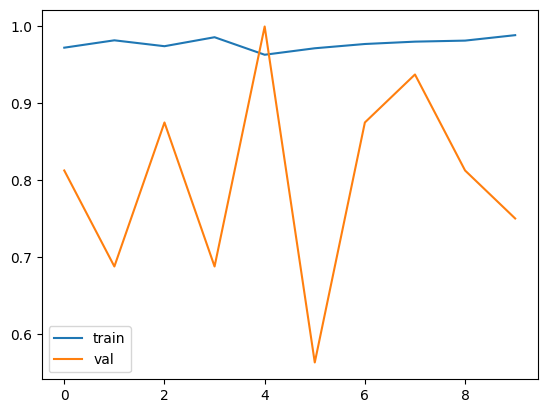

In [78]:
# Plot training and validation accuracies
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.legend()
plt.show()

# Load the best model weights and save them to a file
#model.load_state_dict(best_val_accuracy)
#torch.save(model.state_dict(), 'best_model_weights.pth')

In [79]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.8109


### So this looks strange, and the accuracy, even with a model trained on chest x-rays, is not as good as the guided excercise, so we should try another model.

## Model 2

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ENmodel = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ENmodel.parameters())

Loaded pretrained weights for efficientnet-b0


In [86]:
# Train model
n_epochs = 25
patience = 5
best_val_acc = 0.0
early_stop_count = 0

for epoch in tqdm(range(n_epochs)):
    # Train
    stepcount = 0
    ENmodel.train()
    train_losses = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        stepcount += 1
        if stepcount % 20 == 0:
            print(f"Step {stepcount} Complete")

    # Evaluate on validation set
    ENmodel.eval()
    val_losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
    val_acc = correct / total

    # Print training and validation losses and accuracy
    train_loss = sum(train_losses) / len(train_losses)
    val_loss = sum(val_losses) / len(val_losses)
    print(f"Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}, val accuracy = {val_acc:.4f}")

    # Check if validation accuracy has improved
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_count = 0
        torch.save(ENmodel.state_dict(), "efficientnet.pth")
        print("Model saved")
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print("Early stopping")
            break



  0%|          | 0/25 [00:00<?, ?it/s]

Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


  4%|▍         | 1/25 [1:00:07<24:03:01, 3607.56s/it]

Epoch 1: train loss = 0.7249, val loss = 0.7170, val accuracy = 0.3750
Model saved
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


  8%|▊         | 2/25 [1:59:06<22:47:28, 3567.34s/it]

Epoch 2: train loss = 0.7224, val loss = 0.7261, val accuracy = 0.3750
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 12%|█▏        | 3/25 [2:58:10<21:44:06, 3556.67s/it]

Epoch 3: train loss = 0.7240, val loss = 0.7291, val accuracy = 0.3125
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 16%|█▌        | 4/25 [3:57:15<20:43:12, 3552.02s/it]

Epoch 4: train loss = 0.7253, val loss = 0.7327, val accuracy = 0.4375
Model saved
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 20%|██        | 5/25 [4:56:44<19:46:04, 3558.21s/it]

Epoch 5: train loss = 0.7246, val loss = 0.6899, val accuracy = 0.6250
Model saved
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 24%|██▍       | 6/25 [5:55:45<18:44:49, 3552.10s/it]

Epoch 6: train loss = 0.7242, val loss = 0.7201, val accuracy = 0.4375
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 28%|██▊       | 7/25 [6:54:45<17:44:30, 3548.39s/it]

Epoch 7: train loss = 0.7239, val loss = 0.7119, val accuracy = 0.3750
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 32%|███▏      | 8/25 [7:53:22<16:42:32, 3538.39s/it]

Epoch 8: train loss = 0.7235, val loss = 0.7099, val accuracy = 0.4375
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 36%|███▌      | 9/25 [8:52:30<15:44:20, 3541.26s/it]

Epoch 9: train loss = 0.7243, val loss = 0.7212, val accuracy = 0.4375
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 40%|████      | 10/25 [9:51:27<14:45:01, 3540.08s/it]

Epoch 10: train loss = 0.7228, val loss = 0.6942, val accuracy = 0.6875
Model saved
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 44%|████▍     | 11/25 [10:50:22<13:45:37, 3538.41s/it]

Epoch 11: train loss = 0.7238, val loss = 0.7337, val accuracy = 0.3125
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 48%|████▊     | 12/25 [11:49:23<12:46:49, 3539.23s/it]

Epoch 12: train loss = 0.7228, val loss = 0.7174, val accuracy = 0.3750
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 52%|█████▏    | 13/25 [12:48:19<11:47:37, 3538.11s/it]

Epoch 13: train loss = 0.7231, val loss = 0.7458, val accuracy = 0.2500
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 56%|█████▌    | 14/25 [13:47:33<10:49:32, 3542.92s/it]

Epoch 14: train loss = 0.7215, val loss = 0.7004, val accuracy = 0.5000
Step 20 Complete
Step 40 Complete
Step 60 Complete
Step 80 Complete


 56%|█████▌    | 14/25 [14:46:39<11:36:39, 3800.00s/it]

Epoch 15: train loss = 0.7235, val loss = 0.6801, val accuracy = 0.6875
Early stopping


In [88]:
# Load best model and evaluate on test set
ENmodel.load_state_dict(torch.load("efficientnet.pth"))
ENmodel.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = ENmodel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.6058


#### This is still not ideal, so I have to find something to do better.

## Model 3

### Since PyTorch doesn't seem great for this, maybe TensorFlow will be better.

In [5]:
train_path = input_path + 'train/'
val_path = input_path + 'val/'
test_path = input_path + 'test/' 
labels = ['NORNAL', 'PNEUMONIA']